# **第8章: ニューラルネット**

*深層学習フレームワークの使い方を学び，ニューラルネットワークに基づくカテゴリ分類を実装します．*

第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

## 70 単語ベクトルの和による特徴量

In [3]:
import numpy as np
import pandas as pd

names = ('id','title','url','publisher','category','story','hostname','timestamp')

train = pd.read_csv('train.txt', sep='\t', names=names)
valid = pd.read_csv('valid.txt', sep='\t', names=names)
test = pd.read_csv('test.txt', sep='\t', names=names)

In [129]:
category_to_number = np.vectorize({'b':0, 't':1, 'e':2, 'm':3}.get)

y_train = category_to_number(train['category'])
np.save('y_train.npy', y_train)

y_valid = category_to_number(valid['category'])
np.save('y_valid.npy', y_valid)

y_test = category_to_number(test['category'])
np.save('y_test.npy', y_test)

In [ ]:
from pymagnitude import Magnitude

vecs = Magnitude('GoogleNews-vectors-negative300.magnitude')

In [94]:
def title_to_vector(title):
    words = title.split(' ') #lesson learned: use spacy for tokenization
    vectors = np.vectorize(vecs.query, otypes=[list])(words) #lesson learned: ignore words absent in vecs
    mean = np.mean(vectors, axis=0)
    return mean

def series_to_matrix(series):
    matrix = np.vectorize(title_to_vector, otypes=[list])(series)
    matrix = np.array(matrix.tolist())
    return matrix

In [95]:
x_valid = series_to_matrix(valid['title'])
np.save('x_valid.npy', x_valid)

x_train = series_to_matrix(train['title'])
np.save('x_train.npy', x_train)

x_test = series_to_matrix(test['title'])
np.save('x_test.npy', x_test)

## 71 単層ニューラルネットワークによる予測

In [1]:
import numpy as np
import torch
from torch import nn

x_train = np.load('x_train.npy')
x_valid = np.load('x_valid.npy')
x_test = np.load('x_test.npy')

x_train = torch.from_numpy(x_train)
x_valid = torch.from_numpy(x_valid)
x_test = torch.from_numpy(x_test)

y_train = np.load('y_train.npy')
y_valid = np.load('y_valid.npy')
y_test = np.load('y_test.npy')

y_train = torch.from_numpy(y_train)
y_valid = torch.from_numpy(y_valid)
y_test = torch.from_numpy(y_test)

In [8]:
torch.manual_seed(42)
W = torch.randn(300, 4, dtype=torch.float64, requires_grad=True)
print(W)

tensor([[ 0.2996,  0.2424,  0.2832, -0.2329],
        [ 0.6712,  0.7818, -1.7903, -1.7484],
        [ 0.1735,  0.2668,  0.4285,  0.2319],
        ...,
        [-0.2673, -0.0674, -0.5364, -0.7094],
        [ 1.7440, -0.8126, -1.5970, -1.2687],
        [-0.9292,  0.9032,  2.2692,  0.4099]], dtype=torch.float64,
       requires_grad=True)


In [10]:
y1_hat = torch.softmax(torch.matmul(x_train[0], W), dim=0)
y1_hat

tensor([0.4024, 0.1357, 0.2936, 0.1683], dtype=torch.float64,
       grad_fn=<SoftmaxBackward0>)

In [11]:
y_hat = torch.softmax(torch.mm(x_train[:4], W), dim=-1)
y_hat

tensor([[0.4024, 0.1357, 0.2936, 0.1683],
        [0.2926, 0.1469, 0.3945, 0.1661],
        [0.2665, 0.1099, 0.3960, 0.2276],
        [0.2401, 0.1632, 0.4212, 0.1754]], dtype=torch.float64,
       grad_fn=<SoftmaxBackward0>)

## 72 損失と勾配の計算

In [12]:
from torch import nn

loss = nn.CrossEntropyLoss(reduction='mean')

In [13]:
output = loss(torch.matmul(x_train[0], W), y_train[0])

print("Loss:\n\n", output)

W.grad = None 
output.backward()
print("\nGradients:\n\n", W.grad)

Loss:

 tensor(0.9103, dtype=torch.float64, grad_fn=<NllLossBackward0>)

Gradients:

 tensor([[-0.0166,  0.0038,  0.0081,  0.0047],
        [-0.0122,  0.0028,  0.0060,  0.0034],
        [ 0.0066, -0.0015, -0.0032, -0.0019],
        ...,
        [-0.0204,  0.0046,  0.0100,  0.0057],
        [-0.0099,  0.0022,  0.0049,  0.0028],
        [ 0.0014, -0.0003, -0.0007, -0.0004]], dtype=torch.float64)


In [14]:
output = loss(torch.mm(x_train[:4], W), y_train[:4])

print("Loss:\n\n", output)

W.grad = None
output.backward()
print("\nGradients:\n\n", W.grad)

Loss:

 tensor(0.9826, dtype=torch.float64, grad_fn=<NllLossBackward0>)

Gradients:

 tensor([[-1.2591e-03,  5.2066e-04,  8.1337e-05,  6.5707e-04],
        [-1.3372e-03,  8.1685e-04, -1.0118e-04,  6.2150e-04],
        [ 4.2805e-03, -9.8710e-05, -3.6584e-03, -5.2338e-04],
        ...,
        [-6.8255e-03, -2.1908e-03,  1.1669e-02, -2.6532e-03],
        [-4.3994e-03,  2.3370e-03, -7.8495e-04,  2.8473e-03],
        [ 7.0129e-03, -8.0250e-04, -5.3293e-03, -8.8104e-04]],
       dtype=torch.float64)


## 73 確率的勾配降下法による学習

## 74 正解率の計測

## 75 損失と正解率のプロット

In [59]:
import matplotlib.pyplot as plt

n_epoch = 100
learn_rate = 0.1

class Evaluator:
    
    def __init__(self):
        self.losses_train = []
        self.losses_valid = []
        self.accs_train = []
        self.accs_valid = []
    
    def append(self, W, loss):
        loss_train = loss(torch.mm(x_train, W), y_train).item()
        loss_valid = loss(torch.mm(x_valid, W), y_valid).item()

        self.losses_train.append(loss_train)
        self.losses_valid.append(loss_valid)

        acc_train = (y_train == torch.argmax(torch.mm(x_train, W), dim=-1)).numpy().mean()
        acc_valid = (y_valid == torch.argmax(torch.mm(x_valid, W), dim=-1)).numpy().mean()

        self.accs_train.append(acc_train)
        self.accs_valid.append(acc_valid)
        
    def plot(self):
        ax1 = plt.subplot(211)
        plt.plot(range(len(self.losses_train)), self.losses_train, label='train')
        plt.plot(range(len(self.losses_valid)), self.losses_valid, label='valid')
        plt.legend()
        plt.ylabel('loss')
        plt.tick_params('x', labelbottom=False)

        ax2 = plt.subplot(212, sharex=ax1)
        plt.plot(range(len(self.accs_train)), self.accs_train, label='train')
        plt.plot(range(len(self.accs_valid)), self.accs_valid, label='valid')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')

        plt.show()

evaluator = Evaluator()

torch.manual_seed(42)
W = torch.randn(300, 4, dtype=torch.float64, requires_grad=True)
loss = nn.CrossEntropyLoss(reduction='mean')

In [48]:
from tqdm import tqdm

evaluator.append(W, loss)

for i in tqdm(range(n_epoch)):
    
    for feature, target in zip(x_train, y_train):
        
        output = loss(torch.matmul(feature, W), target)
        
        W.grad = None
        output.backward()
        W.data -= learn_rate * W.grad
        
    evaluator.append(W, loss)    

100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


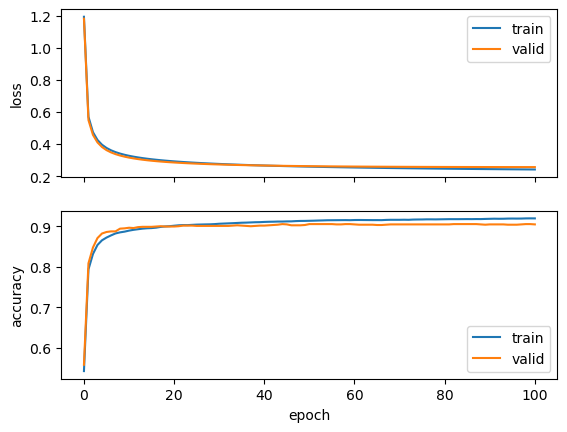

In [50]:
evaluator.plot()

## 76 チェックポイント

In [75]:
from torch.utils.data import TensorDataset, DataLoader

dataset_train = TensorDataset(x_train, y_train)
loader_train = DataLoader(dataset_train, batch_size=1)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(300, 4, bias=False, dtype=torch.float64)
        
    def forward(self, x):
        return self.fc1(x)

torch.manual_seed(42)
model = Net()
evaluator = Evaluator()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loss = nn.CrossEntropyLoss(reduction='mean')

n_epoch = 100

100%|█████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


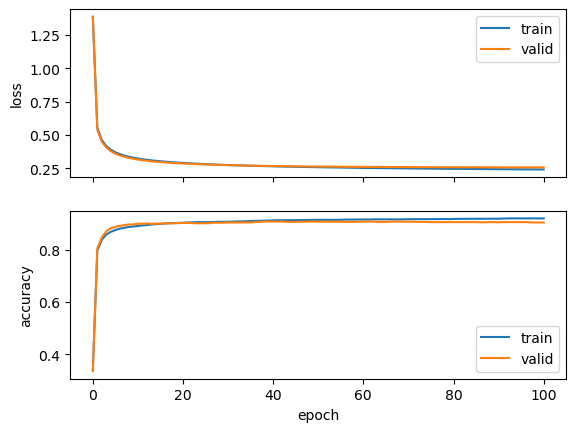

In [76]:
def save_check_point(i):
    torch.save({
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, f'./check_points/{i}.pt')
    
    W = torch.transpose(model.state_dict()['fc1.weight'],0,1)
    evaluator.append(W, loss)

save_check_point(0)
    
for i in tqdm(range(n_epoch)):
    
    for x, y in loader_train:
        optimizer.zero_grad()
        y_hat = model(x)
        output = loss(y_hat, y)
        output.backward()
        optimizer.step()
        
    save_check_point(i+1)

evaluator.plot()

## 77 ミニバッチ化

In [ ]:
from time import process_time

batch_sizes = [2 ** i for i in range(15)]
times = []

dataset_train = TensorDataset(x_train, y_train)
torch.manual_seed(42)
model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loss = nn.CrossEntropyLoss(reduction='mean')
evaluator = Evaluator()

for batch_size in batch_sizes:
    loader_train = DataLoader(dataset_train, batch_size=batch_size)
    
    t = process_time()
    
    for x, y in loader_train:
        optimizer.zero_grad()
        y_hat = model(x)
        output = loss(y_hat, y)
        output.backward()
        optimizer.step()
        
    elapsed_time = process_time() - t
    times.append(elapsed_time)
    
    W = torch.transpose(model.state_dict()['fc1.weight'],0,1)
    evaluator.append(W, loss)

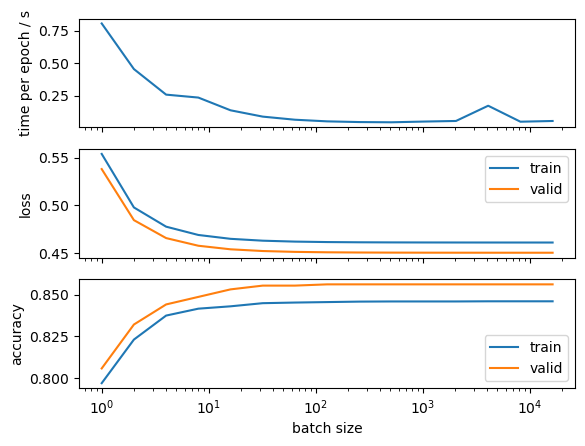

In [124]:
ax1 = plt.subplot(311)
plt.plot(batch_sizes, times)
plt.xscale('log')
plt.ylabel('time per epoch / s')
plt.tick_params('x', labelbottom=False)

ax1 = plt.subplot(312)
plt.plot(batch_sizes, evaluator.losses_train, label='train')
plt.plot(batch_sizes, evaluator.losses_valid, label='valid')
plt.xscale('log')
plt.ylabel('loss')
plt.legend()
plt.tick_params('x', labelbottom=False)

ax1 = plt.subplot(313)
plt.plot(batch_sizes, evaluator.accs_train, label='train')
plt.plot(batch_sizes, evaluator.accs_valid, label='valid')
plt.xscale('log')
plt.xlabel('batch size')
plt.ylabel('accuracy')
plt.legend()

plt.show()

## 78 GPU上での学習

In [136]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#data to gpu
x_train.to(device)
x_valid.to(device)
x_test.to(device)
y_train.to(device)
y_valid.to(device)
y_test.to(device)

batch_sizes = [2 ** i for i in range(15)]
times = []

dataset_train = TensorDataset(x_train, y_train)
torch.manual_seed(42)
model = Net()
model.cpu() if device.type == 'cpu' else model.cuda() # model to gpu
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loss = nn.CrossEntropyLoss(reduction='mean')
evaluator = Evaluator()

for batch_size in batch_sizes:
    loader_train = DataLoader(dataset_train, batch_size=batch_size)
    
    t = process_time()
    
    for x, y in loader_train:
        optimizer.zero_grad()
        y_hat = model(x)
        output = loss(y_hat, y)
        output.backward()
        optimizer.step()
        
    elapsed_time = process_time() - t
    times.append(elapsed_time)
    
    W = torch.transpose(model.state_dict()['fc1.weight'],0,1)
    evaluator.append(W, loss)

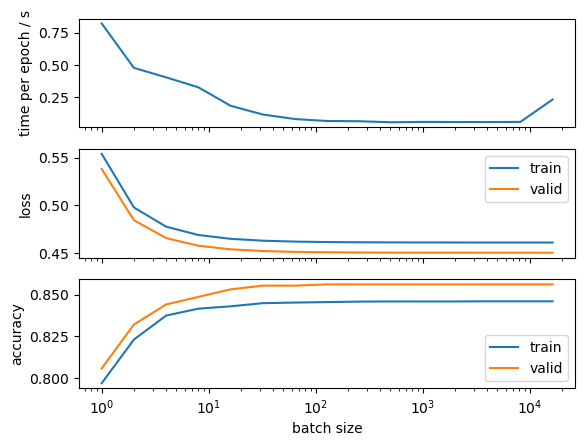

In [137]:
ax1 = plt.subplot(311)
plt.plot(batch_sizes, times)
plt.xscale('log')
plt.ylabel('time per epoch / s')
plt.tick_params('x', labelbottom=False)

ax1 = plt.subplot(312)
plt.plot(batch_sizes, evaluator.losses_train, label='train')
plt.plot(batch_sizes, evaluator.losses_valid, label='valid')
plt.xscale('log')
plt.ylabel('loss')
plt.legend()
plt.tick_params('x', labelbottom=False)

ax1 = plt.subplot(313)
plt.plot(batch_sizes, evaluator.accs_train, label='train')
plt.plot(batch_sizes, evaluator.accs_valid, label='valid')
plt.xscale('log')
plt.xlabel('batch size')
plt.ylabel('accuracy')
plt.legend()

plt.show()

## 79 多層ニューラルネットワーク

In [138]:
class SuperEvaluator(Evaluator):
    
    def append(self, model, loss):
        loss_train = loss(model(x_train), y_train).item()
        loss_valid = loss(model(x_valid), y_valid).item()

        self.losses_train.append(loss_train)
        self.losses_valid.append(loss_valid)

        acc_train = (y_train == torch.argmax(model(x_train), dim=-1)).numpy().mean()
        acc_valid = (y_valid == torch.argmax(model(x_valid), dim=-1)).numpy().mean()

        self.accs_train.append(acc_train)
        self.accs_valid.append(acc_valid)

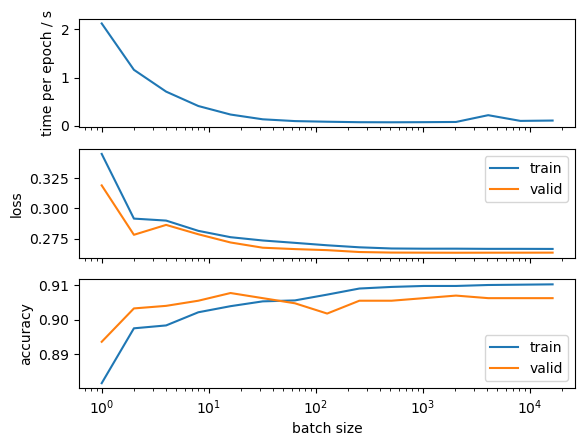

In [140]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(300, 300, dtype=torch.float64)
        self.fc2 = nn.Linear(300, 4, dtype=torch.float64)
        
    def forward(self, x):
        return self.fc2(self.fc1(x))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_train.to(device)
x_valid.to(device)
x_test.to(device)

y_train.to(device)
y_valid.to(device)
y_test.to(device)

batch_sizes = [2 ** i for i in range(15)]
times = []

dataset_train = TensorDataset(x_train, y_train)
torch.manual_seed(42)
model = Net()
model.cpu() if device.type == 'cpu' else model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loss = nn.CrossEntropyLoss(reduction='mean')
evaluator = SuperEvaluator()

for batch_size in batch_sizes:
    loader_train = DataLoader(dataset_train, batch_size=batch_size)
    
    t = process_time()
    
    for x, y in loader_train:
        optimizer.zero_grad()
        y_hat = model(x)
        output = loss(y_hat, y)
        output.backward()
        optimizer.step()
        
    elapsed_time = process_time() - t
    times.append(elapsed_time)
    
    W = torch.transpose(model.state_dict()['fc1.weight'],0,1)
    evaluator.append(model, loss)

# Graphing
    
ax1 = plt.subplot(311)
plt.plot(batch_sizes, times)
plt.xscale('log')
plt.ylabel('time per epoch / s')
plt.tick_params('x', labelbottom=False)

ax1 = plt.subplot(312)
plt.plot(batch_sizes, evaluator.losses_train, label='train')
plt.plot(batch_sizes, evaluator.losses_valid, label='valid')
plt.xscale('log')
plt.ylabel('loss')
plt.legend()
plt.tick_params('x', labelbottom=False)

ax1 = plt.subplot(313)
plt.plot(batch_sizes, evaluator.accs_train, label='train')
plt.plot(batch_sizes, evaluator.accs_valid, label='valid')
plt.xscale('log')
plt.xlabel('batch size')
plt.ylabel('accuracy')
plt.legend()

plt.show()